<a href="https://colab.research.google.com/github/Semanur-Ucdag/BackgroundWorker/blob/master/ADVANCED_GANFaceGenerative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import torch, torchvision, os , PIL, pdb
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def show (tensor, num=25, wandbactive =0, name=''): #burada bir değişim olabilir
  data = tensor.detach().cpu()
  grid = make_grid(data[:num], nrow=5).permute(1,2,0)

  ## optional
  if (wandbactive==1 ): #and wandbact == 1
    wandb.log({name:wandb.Image(grid.numpy().clip(0,1))})


  plt.imshow(grid.clip(0,1))
  plt.show()


### hyperparameters and general parameters
n_epochs =20
batch_size=32
lr=1e-4
z_dim=200
device='cpu' #gpu

cur_step=0
crit_cycles=5
gen_losses=[]
crit_losses=[]
show_step=35
save_step=35

wandbact=1 #yes,we want to track stats through weights and biases, optional





In [ ]:
### optional
!pip install wandb -qqq
import wandb
wandb.login(key = 'de5c2b1a325ea05f63b9be1dd1ae35429ad1dcd8')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:


#%%capture
experiment_name= wandb.util.generate_id()


myrun=wandb.init(
    project='wgan',
    group=experiment_name,
    config={
        "optimizer": "adam",
        "model":"wgan gp",
        "epoch":"20",
        "batch_size":32
    }
)
config=wandb.config

In [ ]:
print(experiment_name)

w8hygpku


In [ ]:
class Generator(nn.Module):
  def __init__(self, z_dim=64, d_dim=16):
    super(Generator, self).__init__()
    self.z_dim=z_dim

    self.gen =nn.Sequential(
        ##ConvTranspose2d: in_channels, out_channels, kernel_size, stride=1, padding=0
        ##Xalculating new width and height: (n-1)*stride -2*padding +ks
        ##n=width or height
        #ks= kernel size
        ##we begin with a 1x1 image with z_dim number of channels(200)
        nn.ConvTranspose2d(z_dim, d_dim*32, 4, 1, 0),## 4x4 (ch:200,512)
        nn.BatchNorm2d(d_dim*32),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*32, d_dim*16, 4, 2, 1),##8x8(ch:512,256)
        nn.BatchNorm2d(d_dim*16),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*16, d_dim*8, 4, 2, 1),##16x16(ch:256,128)
        #(n-1)*stride -2*padding +ks= (8-1)*2-2*1+4=16
        nn.BatchNorm2d(d_dim*8),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*8, d_dim*4, 4, 2, 1),##32x32(ch:128,64)
        nn.BatchNorm2d(d_dim*4),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*4, d_dim*2, 4, 2, 1),##64x64(ch:64,32)
        nn.BatchNorm2d(d_dim*2),
        nn.ReLU(True),

        nn.ConvTranspose2d(d_dim*2, 3, 4, 2, 1),##128x128(ch:32,3)
        nn.Tanh()##PRODUCe result in the range from -1 to 1

    )

  def forward(self, noise):
    x=noise.view(len(noise), self.z_dim, 1,1)##18x20x1x1
    return self.gen(x)


def gen_noise(num, z_dim, device='cpu'):
  return torch.randn(num, z_dim, device=device)#128x200

In [ ]:
##critic model


class Critic(nn.Module):
  def __init__(self, d_dim=16):
    super(Critic, self).__init__()

    self.crit=nn.Sequential(
    #nn.ConvTranspose2d: (n-1)*stride -2*padding +ks
    #nn.Conv2d:(n+2*pad-ks)//stride +1
    nn.Conv2d(3, d_dim, 4, 2, 1),##(n+2*pad-ks)//stride +1 (128+2*1-4)//2+1=64x64 (ch:3,16)
    nn.InstanceNorm2d(d_dim),
    nn.LeakyReLU(0.2),

    nn.Conv2d(d_dim, d_dim*2, 4, 2, 1),##32X32 (ch: 16,32)
    nn.InstanceNorm2d(d_dim*2),
    nn.LeakyReLU(0.2),

    nn.Conv2d(d_dim*2, d_dim*4, 4, 2, 1),##16x16 (ch: 32,64)
    nn.InstanceNorm2d(d_dim*4),
    nn.LeakyReLU(0.2),

    nn.Conv2d(d_dim*4, d_dim*8, 4, 2, 1),##8x8 (ch: 64,128)
    nn.InstanceNorm2d(d_dim*8),
    nn.LeakyReLU(0.2),

    nn.Conv2d(d_dim*8, d_dim*16, 4, 2, 1),##4x4 (ch: 128,256)
    nn.InstanceNorm2d(d_dim*16),
    nn.LeakyReLU(0.2),

    nn.Conv2d(d_dim*16, 1, 4, 1, 0),##(n+2*pad-ks)//stride +1 =(4+2*0-4)//1+1=1x1 (ch:256,1)
    )
  def forward(self,image):
    #image: 128x3x128x128
    crit_pred=self.crit(image)#128x1x1x1x
    return crit_pred.view(len(crit_pred), -1)##128x1



In [ ]:
##optional , init your weights in different ways
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

    ##gen=gen.apply(init_weights)
    ##crit=crit.apply(init_weights)



In [ ]:
#load dataset
import gdown  #https://drive.google.com/drive/folders/1-2UumHVKrSSe3Sg8m0jJFaNqfcHv_TLN?usp=drive_link
import zipfile
import os
url= 'https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a'
path='data/celeba'
download_path=f'{path}/img_align_celeba.zip'

if not os.path.exists(path):
  os.makedirs(path)

gdown.download(url, download_path, quiet=False)

with zipfile.ZipFile(download_path, 'r') as ziphandler:
    ziphandler.extractall(path)



Downloading...
From: https://dl.dropboxusercontent.com/scl/fi/vltmt8hlgdf9mv9kn7d0b/img_align_celeba.zip?rlkey=tacwpkr8d9bjpctdftjg3b00a
To: /content/data/celeba/img_align_celeba.zip
100%|██████████| 1.44G/1.44G [00:19<00:00, 75.7MB/s]


In [ ]:
!pip install intel-extension-for-pytorch[xpu]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97.5 MB 10.4 MB/s eta 0:00:00


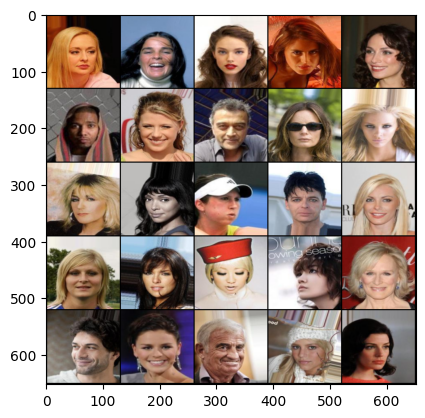

In [ ]:
##Düzelttim bu kısmı artık çalışıyor
### Dataset , DataLoader, declare gen , crit, test dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
   def __init__(self, path, size=128, lim=5000):#10000 idi 100 yapıtm
      self.sizes=[size, size]
      items,labels=[],[]


      for data in os.listdir(path)[:lim]:
       # path: './content/data/celeba/img_align_celeba.zip'
        #data: '114568.jpg'
        item = os.path.join(path,data)
        items.append(item)
        labels.append(data)

      self.items=items
      self.labels=labels


   def __len__(self):
      return len(self.items)

   def __getitem__(self, idx):
      data = PIL.Image.open(self.items[idx]).convert('RGB') #(178,218)
      data =  np.asarray(torchvision.transforms.Resize(self.sizes)(data))##128x128x3
      data =  np.transpose(data, (2,0,1)).astype(np.float32, copy=False)# 3x128x128 # froem 0 to 255
      data =  torch.from_numpy(data).div(255)#from 0 to 1
      return data, self.labels[idx]

      ##Dataset

data_path = './data/celeba/img_align_celeba'
ds = MyDataset(data_path, size= 128,  lim=5000)#10000 idi 100 yaptım


    ##DataLoader
dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True)

    ##Models
gen = Generator(z_dim).to(device)
crit = Critic().to(device)

    ##Optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(0.5, 0.9))

    ##Loss
#crit_loss = nn.BCEWithLogitsLoss()

  ##Initializations
  ##gen=gen.apply(init_weights)
  ##crit=crit.apply(init_weights)

  #wandb optional
if (wandbact==1):
    wandb.watch(gen, log_freq= 100)
    wandb.watch(crit, log_freq= 100)


x,y = next(iter(dataloader))
show(x)

In [ ]:
## gradient penalty calculation

def get_gp(real, fake, crit, alpha, gamma=10):
  mix_images = real * alpha + fake * (1 - alpha) #128x3x128x128
  mix_scores = crit(mix_images)

  gradient = torch.autograd.grad(
      inputs = mix_images,
      outputs = mix_scores,
      grad_outputs=torch.ones_like(mix_scores),#.to(device)
      retain_graph=True,
      create_graph=True,
  )[0]

  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  gp = gamma * ((gradient_norm-1)**2).mean()

  return gp

In [ ]:
## Save and load checkpoints
root_path= './data/'

def save_checkpoint(name):
  torch.save({
      'epoch': epoch,
      'model_state_dict': gen.state_dict(),
      'optimizer_state_dict': gen_opt.state_dict(),

  }, f"{root_path}G-{name}.pkl")
  torch.save({
      'epoch': epoch,
      'model_state_dict': crit.state_dict(),
      'optimizer_state_dict': crit_opt.state_dict(),

  }, f"{root_path}C-{name}.pkl")

  print("Saved checkpoint")

def load_checkpoint(name):
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
  gen.load_state_dict(checkpoint['model_state_dict'])
  gen_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  checkpoint = torch.load(f"{root_path}C-{name}.pkl")
  crit.load_state_dict(checkpoint['model_state_dict'])
  crit_opt.load_state_dict(checkpoint['optimizer_state_dict'])

  print("Loaded checkpoint")


In [ ]:
epoch = 1
save_checkpoint("test")


Saved checkpoint


In [ ]:
load_checkpoint("test")

Loaded checkpoint


<ipython-input-15-154c04f70756>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{root_path}G-{name}.pkl")
<ipython-input-15-154c04f70756>:25: Fut

In [ ]:
#training loop

for epoch in range(n_epochs):
 for real, _ in tqdm(dataloader):
    cur_bs = len(real)
    real = real.to(device)

    ###CRITIC
    mean_crit_loss = 0
    for _ in range(crit_cycles):
      crit_opt.zero_grad()

      noise = gen_noise(cur_bs, z_dim)
      fake = gen(noise)
      crit_fake_pred = crit(fake.detach())
      crit_real_pred = crit(real)

      alpha = torch.rand(len(real),1,1,1,device = device, requires_grad=True) #128x1x1x1
      gp = get_gp(real, fake.detach(), crit, alpha)

      crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
      mean_crit_loss+= crit_loss.item() / crit_cycles
      crit_loss.backward(retain_graph=True)
      crit_opt.step()

    crit_losses += [mean_crit_loss]

   ###GENERATOR
    gen_opt.zero_grad()
    noise = gen_noise(cur_bs, z_dim)
    fake = gen(noise)
    crit_fake_pred = crit(fake)

    gen_loss = -crit_fake_pred.mean()
    gen_loss.backward()
    gen_opt.step()

    gen_losses += [gen_loss.item()]

 ## STATS
#if (wandbact==1):
    wandb.log({"Epoch": epoch, 'Step': cur_step, 'Critic Loss': mean_crit_loss, 'Gen Loss': gen_loss})

if cur_step % save_step == 0  and cur_step >0:
    print("Saving checkpoint: ", cur_step, save_step)
    save_checkpoint("latest")

##if (cur_step % show_step == 0 and cur_step>0):
 ##    show(fake, wandbactive = 1, name= 'fake')
   ##  show(real, wandbactive = 1, name='real')
if (cur_step % show_step == 0 and cur_step > 0):
            # Görselleri WandB'ye logla
      fake = fake[:8].detach().cpu()  # İlk 8 sahte görüntü
      real = real[:8].detach().cpu()  # İlk 8 gerçek görüntü

      wandb.log({
           "Fake Images": [wandb.Image(img, caption=f"Fake Image {i}") for i, img in enumerate(fake)],
            "Real Images": [wandb.Image(img, caption=f"Real Image {i}") for i, img in enumerate(real)]
            })
      gen_mean=sum(gen_losses[-show_step:]) / show_step
      crit_mean=sum(crit_losses[-show_step:]) / show_step
      print(f"Epoch: {epoch}: Step {cur_step}: Generator Loss: {gen_mean}, critic loss: {crit_mean} ")

      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(gen_losses),
          label = "Generator Loss"
      )
      plt.plot(
          range(len(gen_losses)),
          torch.Tensor(crit_losses),
          label="Critic Loss"
      )

In [ ]:
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_bs = len(real)
        real = real.to(device)

        ### CRITIC UPDATE
        mean_crit_loss = 0
        for _ in range(crit_cycles):
            crit_opt.zero_grad()

            noise = gen_noise(cur_bs, z_dim)
            fake = gen(noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            alpha = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gp = get_gp(real, fake.detach(), crit, alpha)

            crit_loss = crit_fake_pred.mean() - crit_real_pred.mean() + gp
            mean_crit_loss += crit_loss.item() / crit_cycles
            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        crit_losses.append(mean_crit_loss)

        ### GENERATOR UPDATE
        gen_opt.zero_grad()
        noise = gen_noise(cur_bs, z_dim)
        fake = gen(noise)
        crit_fake_pred = crit(fake)

        gen_loss = -crit_fake_pred.mean()
        gen_loss.backward()
        gen_opt.step()

        gen_losses.append(gen_loss.item())

        ### LOGGING
        cur_step += 1
        if cur_step % save_step == 0:
            print("Saving checkpoint...")
            save_checkpoint("latest")

        if cur_step % show_step == 0:
            fake = fake[:8].detach().cpu().permute(0, 2, 3, 1).clip(0, 1)
            real = real[:8].detach().cpu().permute(0, 2, 3, 1).clip(0, 1)

            wandb.log({
                "Fake Images": [wandb.Image(img.numpy(), caption=f"Fake Image {i}") for i, img in enumerate(fake)],
                "Real Images": [wandb.Image(img.numpy(), caption=f"Real Image {i}") for i, img in enumerate(real)],
                "Critic Loss": mean_crit_loss,
                "Generator Loss": gen_loss.item()
            })

            print(f"Epoch: {epoch}, Step: {cur_step}, Generator Loss: {gen_loss.item()}, Critic Loss: {mean_crit_loss}")


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 0, Step: 70, Generator Loss: 9.833015441894531, Critic Loss: -9.99081802368164
Saving checkpoint...
Saved checkpoint
Epoch: 0, Step: 105, Generator Loss: 17.471113204956055, Critic Loss: -23.413746261596682
Saving checkpoint...
Saved checkpoint
Epoch: 0, Step: 140, Generator Loss: 24.963571548461914, Critic Loss: -26.513721084594728
Saving checkpoint...
Saved checkpoint
Epoch: 0, Step: 175, Generator Loss: 23.929567337036133, Critic Loss: -22.02726135253906
Saving checkpoint...
Saved checkpoint
Epoch: 0, Step: 210, Generator Loss: 29.559062957763672, Critic Loss: -25.648163604736325


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 1, Step: 245, Generator Loss: 22.810440063476562, Critic Loss: -15.944944190979005
Saving checkpoint...
Saved checkpoint
Epoch: 1, Step: 280, Generator Loss: 22.69127655029297, Critic Loss: -16.117604637145995
Saving checkpoint...
Saved checkpoint
Epoch: 1, Step: 315, Generator Loss: 25.679080963134766, Critic Loss: -15.25341968536377
Saving checkpoint...
Saved checkpoint
Epoch: 1, Step: 350, Generator Loss: 19.272714614868164, Critic Loss: -14.083226203918457


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 2, Step: 385, Generator Loss: 17.05618667602539, Critic Loss: -11.348895072937012
Saving checkpoint...
Saved checkpoint
Epoch: 2, Step: 420, Generator Loss: 13.951822280883789, Critic Loss: -12.37217025756836
Saving checkpoint...
Saved checkpoint
Epoch: 2, Step: 455, Generator Loss: 12.464614868164062, Critic Loss: -12.841398811340332
Saving checkpoint...
Saved checkpoint
Epoch: 2, Step: 490, Generator Loss: 12.16706371307373, Critic Loss: -12.205836486816406
Saving checkpoint...
Saved checkpoint
Epoch: 2, Step: 525, Generator Loss: 23.692859649658203, Critic Loss: -10.094657802581787


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 3, Step: 560, Generator Loss: 12.442601203918457, Critic Loss: -10.413313102722167
Saving checkpoint...
Saved checkpoint
Epoch: 3, Step: 595, Generator Loss: 12.507282257080078, Critic Loss: -10.061735725402832
Saving checkpoint...
Saved checkpoint
Epoch: 3, Step: 630, Generator Loss: 18.870098114013672, Critic Loss: -12.115160942077637
Saving checkpoint...
Saved checkpoint
Epoch: 3, Step: 665, Generator Loss: 18.875133514404297, Critic Loss: -8.717268753051759


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 4, Step: 700, Generator Loss: 12.38694953918457, Critic Loss: -8.727816772460937
Saving checkpoint...
Saved checkpoint
Epoch: 4, Step: 735, Generator Loss: 17.19802474975586, Critic Loss: -12.294606399536134
Saving checkpoint...
Saved checkpoint
Epoch: 4, Step: 770, Generator Loss: 7.293217658996582, Critic Loss: -10.083541488647462
Saving checkpoint...
Saved checkpoint
Epoch: 4, Step: 805, Generator Loss: 14.804577827453613, Critic Loss: -11.162303352355956


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 5, Step: 840, Generator Loss: 7.083682060241699, Critic Loss: -8.695929527282715
Saving checkpoint...
Saved checkpoint
Epoch: 5, Step: 875, Generator Loss: 20.71705436706543, Critic Loss: -10.230894470214844
Saving checkpoint...
Saved checkpoint
Epoch: 5, Step: 910, Generator Loss: 16.6274356842041, Critic Loss: -9.279033279418945
Saving checkpoint...
Saved checkpoint
Epoch: 5, Step: 945, Generator Loss: 12.029852867126465, Critic Loss: -6.56270694732666
Saving checkpoint...
Saved checkpoint
Epoch: 5, Step: 980, Generator Loss: 19.707895278930664, Critic Loss: -9.687022018432618


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 6, Step: 1015, Generator Loss: 11.454327583312988, Critic Loss: -9.022428131103515
Saving checkpoint...
Saved checkpoint
Epoch: 6, Step: 1050, Generator Loss: 13.341758728027344, Critic Loss: -6.413525676727295
Saving checkpoint...
Saved checkpoint
Epoch: 6, Step: 1085, Generator Loss: 12.798593521118164, Critic Loss: -9.191711616516113
Saving checkpoint...
Saved checkpoint
Epoch: 6, Step: 1120, Generator Loss: 9.441798210144043, Critic Loss: -10.242570686340333


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 7, Step: 1155, Generator Loss: 13.917556762695312, Critic Loss: -7.398891830444336
Saving checkpoint...
Saved checkpoint
Epoch: 7, Step: 1190, Generator Loss: 4.362629413604736, Critic Loss: -10.532489490509032
Saving checkpoint...
Saved checkpoint
Epoch: 7, Step: 1225, Generator Loss: 13.542547225952148, Critic Loss: -8.929564762115477
Saving checkpoint...
Saved checkpoint
Epoch: 7, Step: 1260, Generator Loss: 18.23956298828125, Critic Loss: -11.526043128967284
Saving checkpoint...
Saved checkpoint
Epoch: 7, Step: 1295, Generator Loss: 5.828646183013916, Critic Loss: -12.451362419128417


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 8, Step: 1330, Generator Loss: 14.545258522033691, Critic Loss: -9.88323450088501
Saving checkpoint...
Saved checkpoint
Epoch: 8, Step: 1365, Generator Loss: 13.993436813354492, Critic Loss: -9.593422126770019
Saving checkpoint...
Saved checkpoint
Epoch: 8, Step: 1400, Generator Loss: 21.08585548400879, Critic Loss: -10.901399612426758
Saving checkpoint...
Saved checkpoint
Epoch: 8, Step: 1435, Generator Loss: 14.380393981933594, Critic Loss: -8.481305122375488


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 9, Step: 1470, Generator Loss: 16.015520095825195, Critic Loss: -9.371831893920898
Saving checkpoint...
Saved checkpoint
Epoch: 9, Step: 1505, Generator Loss: 13.446680068969727, Critic Loss: -11.452153205871582
Saving checkpoint...
Saved checkpoint
Epoch: 9, Step: 1540, Generator Loss: 14.159141540527344, Critic Loss: -9.036703109741211
Saving checkpoint...
Saved checkpoint
Epoch: 9, Step: 1575, Generator Loss: 11.400074005126953, Critic Loss: -9.263548183441163
Saving checkpoint...
Saved checkpoint
Epoch: 9, Step: 1610, Generator Loss: 12.298075675964355, Critic Loss: -6.447901344299316


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 10, Step: 1645, Generator Loss: 20.746532440185547, Critic Loss: -11.294798278808594
Saving checkpoint...
Saved checkpoint
Epoch: 10, Step: 1680, Generator Loss: 17.838762283325195, Critic Loss: -7.533554458618163
Saving checkpoint...
Saved checkpoint
Epoch: 10, Step: 1715, Generator Loss: 13.383567810058594, Critic Loss: -8.566558074951173
Saving checkpoint...
Saved checkpoint
Epoch: 10, Step: 1750, Generator Loss: 9.845141410827637, Critic Loss: -8.083268070220948


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 11, Step: 1785, Generator Loss: 18.213163375854492, Critic Loss: -8.746832275390624
Saving checkpoint...
Saved checkpoint
Epoch: 11, Step: 1820, Generator Loss: 18.93450927734375, Critic Loss: -12.562522697448731
Saving checkpoint...
Saved checkpoint
Epoch: 11, Step: 1855, Generator Loss: 15.847635269165039, Critic Loss: -7.795553684234618
Saving checkpoint...
Saved checkpoint
Epoch: 11, Step: 1890, Generator Loss: 7.647778511047363, Critic Loss: -7.057268905639648
Saving checkpoint...
Saved checkpoint
Epoch: 11, Step: 1925, Generator Loss: 13.837900161743164, Critic Loss: -7.128714752197265


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 12, Step: 1960, Generator Loss: 16.042137145996094, Critic Loss: -10.128487300872802
Saving checkpoint...
Saved checkpoint
Epoch: 12, Step: 1995, Generator Loss: 19.345985412597656, Critic Loss: -4.300756120681763
Saving checkpoint...
Saved checkpoint
Epoch: 12, Step: 2030, Generator Loss: 13.606712341308594, Critic Loss: -7.804093933105468
Saving checkpoint...
Saved checkpoint
Epoch: 12, Step: 2065, Generator Loss: 8.662327766418457, Critic Loss: -8.170358467102051


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 13, Step: 2100, Generator Loss: 15.224743843078613, Critic Loss: -6.795730113983154
Saving checkpoint...
Saved checkpoint
Epoch: 13, Step: 2135, Generator Loss: 15.357976913452148, Critic Loss: -10.63080253601074
Saving checkpoint...
Saved checkpoint
Epoch: 13, Step: 2170, Generator Loss: 13.006513595581055, Critic Loss: -7.285842514038086
Saving checkpoint...
Saved checkpoint
Epoch: 13, Step: 2205, Generator Loss: 7.164224624633789, Critic Loss: -9.653352069854735
Saving checkpoint...
Saved checkpoint
Epoch: 13, Step: 2240, Generator Loss: 16.141284942626953, Critic Loss: -6.6044701576232905


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 14, Step: 2275, Generator Loss: 13.561790466308594, Critic Loss: -9.793972206115722
Saving checkpoint...
Saved checkpoint
Epoch: 14, Step: 2310, Generator Loss: 11.504114151000977, Critic Loss: -5.525964736938477
Saving checkpoint...
Saved checkpoint
Epoch: 14, Step: 2345, Generator Loss: 22.809770584106445, Critic Loss: -9.580437469482423
Saving checkpoint...
Saved checkpoint
Epoch: 14, Step: 2380, Generator Loss: 14.25174331665039, Critic Loss: -6.578214359283447


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 15, Step: 2415, Generator Loss: 16.707937240600586, Critic Loss: -6.650109767913818
Saving checkpoint...
Saved checkpoint
Epoch: 15, Step: 2450, Generator Loss: 20.79535675048828, Critic Loss: -8.244898414611816
Saving checkpoint...
Saved checkpoint
Epoch: 15, Step: 2485, Generator Loss: 12.323487281799316, Critic Loss: -9.555076599121094
Saving checkpoint...
Saved checkpoint
Epoch: 15, Step: 2520, Generator Loss: 20.570194244384766, Critic Loss: -6.950456619262695
Saving checkpoint...
Saved checkpoint
Epoch: 15, Step: 2555, Generator Loss: 13.848172187805176, Critic Loss: -4.422888612747192


  0%|          | 0/157 [00:00<?, ?it/s]

Saving checkpoint...
Saved checkpoint
Epoch: 16, Step: 2590, Generator Loss: 7.746851921081543, Critic Loss: -10.261872673034668
Saving checkpoint...
Saved checkpoint
Epoch: 16, Step: 2625, Generator Loss: 16.245403289794922, Critic Loss: -9.930621337890624
